In [3]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import math
import numpy as np
import numpy.linalg as la
from PIL import Image

def perc_high(a):
    return np.percentile(a,q=90)

def perc_low(a):
    return np.percentile(a,q=10)

def load_fitness(filename):
    ids = []
    fits = []
    parents = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            if(len(row) == 3):
                parents.append(-1)
            else:
                parents.append(int(row[1]))
            if(float(row[-2]) == 1.0):
                fits.append(0)
            else:
                fits.append(float(row[-2]))    
            ids.append(float(row[0]))
            
    return ids, fits, parents

def find_index(_id,ids):
    for i in range(len(ids)):
        if(ids[i] == _id):
            return i

def compute_gen_rec(par_id,ids,parents):
    if(par_id == -1):
        return 0
    for i, _id in zip(range(len(ids)),ids):
        if(par_id == _id):
            return compute_gen_rec(parents[i],ids,parents) + 1

def compute_generation(ids,parents):
    generation = [0 for _ in range(len(ids))]
    for i in range(len(ids)):
        generation[i] = compute_gen_rec(parents[i],ids,parents)
    return generation

def load_descriptor(filename) :
    '''
    Load a list of descriptor from a file
    Trait descriptor: <width,depth,height,voxels,wheels,sensor,joint,caster>
    '''
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        descriptors = []
        for row in csv_data :
            desc = []
            for i in range(len(row)-1) :
                desc.append(float(row[i]))
            descriptors.append(desc)
        return descriptors
    
def load_controller_archive(filename):
    lines = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        coord = [0]*3
        state = 0
        nbr_param = 0
        i=0
        for row in csv_data:
            if(len(row) == 3):
                coord[0] = int(row[0])
                coord[1] = int(row[1])
                coord[2] = int(row[2])
                state = 1
                i=0
            elif(len(row[0].split(" "))==4):
                continue
            elif(state == 1):
                nbr_param = int(row[0])
                state = 2
            elif(state == 2):
                nbr_param += int(row[0])
                state = 3
            elif(state == 3 and i < nbr_param):
                i+=1
            elif(state == 3 and i >= nbr_param):
                if(coord[1] == 0):
                    lines.append([coord[0],coord[2],float(row[0])])
    return pd.DataFrame(data=lines,columns=["number of wheels","number of sensors","fitness"])

def compute_lineage_rec(ids,par_id,parents):
    if(par_id == -1):
        return []
    for i, _id in zip(range(len(ids)),ids):
        if(par_id == _id):
            return [_id] + compute_lineage_rec(ids,parents[i],parents)
def compute_lineage(ids,parents):
    lineages = dict()
    for i, _id in zip(range(len(ids)),ids):
        lineages[_id] = compute_lineage_rec(ids,parents[i],parents)
    return lineages

def load_trajectory(filename):
    traj = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=';')
        t = 0
        for row in csv_data:
            position = row[0].split(',')
            pos = [float(elt) for elt in position]
            traj.append([t] + pos)
            t+=1
    return traj

def compute_exploration_fitness(desc):
    _sum = 0
    for d in desc:
        _sum += d[1]

    max_sum = 0
    for i in range(8):
        for j in range(8):
            max_sum += math.floor(math.sqrt((i - 3)*(i - 3) + (j - 3)*(j - 3)))
    return float(_sum)/float(max_sum)

def load_grid_descriptor(filename):
    with open(filename) as file:
        state = 0
        descs = dict()    
        _id = 0
        i = 0
        for line in file.readlines():
            if(state == 0):
                _id = int(line)
                state = 1
                descs[_id] = []
                i = 0
            elif(state == 1):
                if(int(line) > 0):
                    descs[_id].append((i,int(line)))
                i+=1
                if(i == 64):
                    state = 0
        return descs
    
def compute_runtime(filename,nbr_eval):
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        i = 0
        start_time = 0
        end_time = 0
        for row in csv_data:
            if(i==0):
                start_time = float(row[1])
            if(row[0] == "overhead"):
                continue
            if(i==nbr_eval):
                end_time = float(row[2])
            i+=1
    return end_time - start_time

def read_parameters(filename):
    '''
    Read a parameter and return a dictionnary
    '''
    parameters = dict()
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            parameters[row[0]] = row[2]
    return parameters

# Generation 0
## Quality

In [4]:
exp_folder = "/home/leni/are-logs/mnipes2_explo_final_experiments/gen_0/"
lines = []
i = 0
best_inds = dict()
beh_descriptors = dict()
morph_descriptors = dict()
for folder in os.listdir(exp_folder):
    i+=1
    ids, fitnesses, parents = load_fitness(exp_folder + "/" + folder + "/fitnesses.csv")
    indexes = np.argsort(np.array(fitnesses))
    best_inds[folder] = [[ids[indexes[-i]],fitnesses[indexes[-i]]*64] for i in range(1,6)]
    print(folder,best_inds[folder])
    generation = compute_generation(ids,parents)
    for idx, _id, fit, gen in zip(range(len(ids)),ids,fitnesses,generation):    
        lines.append([idx,_id,fit,gen])
  
    morph_desc = load_descriptor(exp_folder + "/" + folder + "/morph_descriptors.csv")
    morph_descriptors[folder] = dict()
    for desc in morph_desc:
        morph_descriptors[folder][desc[0]] = desc[1:]
print(i)
data = pd.DataFrame(data=lines,columns=["idx","robot id","fitness","generation"]) 
data.drop_duplicates()

mnipes2_3_10_12-7-27-7383-519529520 [[138.0, 21.0], [136.0, 20.0], [144.0, 20.0], [214.0, 19.0], [111.0, 18.0]]
mnipes2_3_10_12-9-32-2635-1248614990 [[131.0, 18.0], [214.0, 17.0], [179.0, 17.0], [119.0, 17.0], [116.0, 17.0]]
mnipes2_3_10_12-7-28-8831-2489538739 [[156.0, 20.0], [214.0, 18.0], [243.0, 17.0], [73.0, 16.0], [129.0, 16.0]]
mnipes2_3_10_12-7-26-6634-3601984561 [[229.0, 20.0], [101.0, 19.0], [207.0, 17.0], [160.0, 16.0], [171.0, 16.0]]
mnipes2_3_10_12-7-38-8027-3979829036 [[163.0, 18.0], [167.0, 18.0], [172.0, 18.0], [100.0, 18.0], [186.0, 17.0]]
mnipes2_3_10_12-7-26-6695-3397605759 [[191.0, 20.0], [222.0, 20.0], [192.0, 19.0], [210.0, 18.0], [161.0, 18.0]]
mnipes2_3_10_12-9-32-2576-3611603593 [[172.0, 14.0], [149.0, 14.0], [136.0, 13.0], [188.0, 13.0], [119.0, 13.0]]
mnipes2_3_10_12-7-27-7344-1878848956 [[220.0, 20.0], [117.0, 19.0], [213.0, 19.0], [73.0, 19.0], [166.0, 18.0]]
mnipes2_3_10_12-7-26-6646-3234249346 [[154.0, 18.0], [27.0, 16.0], [86.0, 15.0], [128.0, 15.0], [16

,idx,robot id,fitness,generation
0,0,15.0,0.046875,0
1,1,35.0,0.015625,0
2,2,27.0,0.062500,0
3,3,1.0,0.250000,0
4,4,36.0,0.015625,0
...,...,...,...,...
2145,200,222.0,0.000000,8
2146,201,223.0,0.109375,11
2147,202,224.0,0.171875,9
2148,203,225.0,0.015625,11


In [8]:
fig = plt.gcf()
fig.set_size_inches(20,10)
ax = sns.swarmplot(data=data,x="generation",y="fitness",size=2,color='b')
sns.lineplot(data=data,x="generation",y="fitness",estimator=perc_high,label="best 10%")
sns.lineplot(data=data,x="generation",y="fitness",estimator=perc_low,label="worst 10%")
ax.set_title("exploration - side hard")
ax.set_ylim([0,0.6])

205


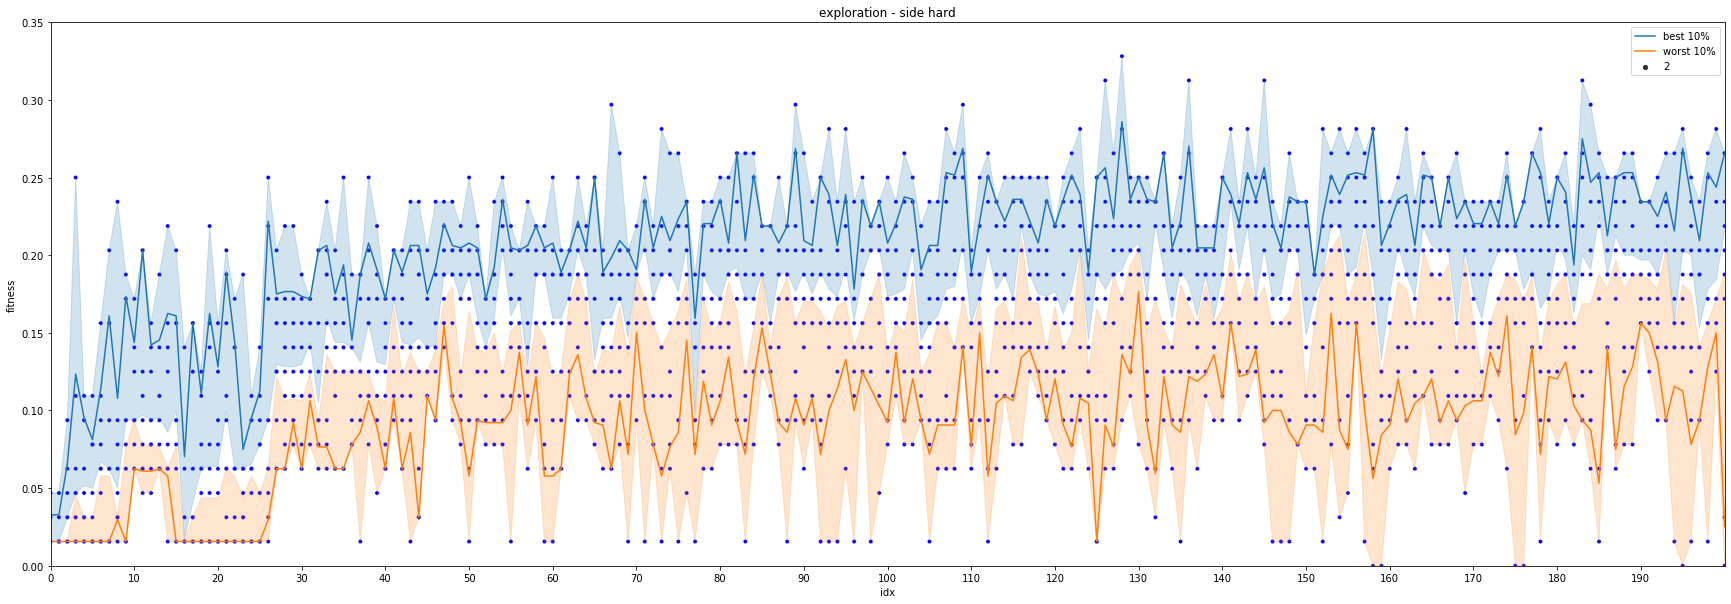

In [16]:
fig = plt.gcf()
fig.set_size_inches(30,10)
ax = sns.scatterplot(data=data,x="idx",y="fitness",size=2,color='b')
sns.lineplot(data=data,x="idx",y="fitness",estimator=perc_high,label="best 10%")
sns.lineplot(data=data,x="idx",y="fitness",estimator=perc_low,label="worst 10%")
ax.set_title("exploration - side hard")
ax.set_ylim([0,0.35])
ax.set_xlim([0,200])
plt.xticks(range(0,200,10),range(0,200,10))
print(len(ids))

# Generation 1
## Quality

In [5]:
exp_folder = "/home/leni/are-logs/mnipes2_explo_final_experiments/gen_1/"
lines = []
i = 0
best_inds = dict()
beh_descriptors = dict()
morph_descriptors = dict()
for folder in os.listdir(exp_folder):
    i+=1
    ids, fitnesses, parents = load_fitness(exp_folder + "/" + folder + "/fitnesses.csv")
    indexes = np.argsort(np.array(fitnesses))
    best_inds[folder] = [[ids[indexes[-i]],fitnesses[indexes[-i]]*64] for i in range(1,6)]
    print(folder,best_inds[folder])
    generation = compute_generation(ids,parents)
    for idx, _id, fit, gen in zip(range(len(ids)),ids,fitnesses,generation):
        lines.append([idx+50,_id,fit,gen])
  
    morph_desc = load_descriptor(exp_folder + "/" + folder + "/morph_descriptors.csv")
    morph_descriptors[folder] = dict()
    for desc in morph_desc:
        morph_descriptors[folder][desc[0]] = desc[1:]
print(i)
data_1 = pd.DataFrame(data=lines,columns=["idx","robot id","fitness","generation"]) 
data_1.drop_duplicates()

mnipes2_9_10_20-47-51-1423-2858225455 [[94.0, 16.0], [159.0, 15.0], [64.0, 15.0], [180.0, 15.0], [100.0, 15.0]]
mnipes2_9_10_17-2-7-7880-3327828549 [[147.0, 25.0], [185.0, 22.0], [142.0, 21.0], [162.0, 21.0], [92.0, 20.0]]
mnipes2_10_10_15-29-1-1882-86016911 [[167.0, 21.0], [122.0, 19.0], [117.0, 18.0], [188.0, 18.0], [33.0, 18.0]]
mnipes2_10_10_10-10-20-371-1854220728 [[192.0, 18.0], [176.0, 17.0], [88.0, 17.0], [35.0, 17.0], [27.0, 17.0]]
mnipes2_9_10_23-6-32-2380-2046351755 [[162.0, 14.0], [78.0, 13.0], [200.0, 13.0], [192.0, 13.0], [174.0, 12.0]]
mnipes2_9_10_20-47-36-7003-2810200260 [[185.0, 19.0], [208.0, 18.0], [196.0, 18.0], [186.0, 17.0], [171.0, 17.0]]
mnipes2_12_10_13-14-10-380-2957617507 [[64.0, 20.0], [13.0, 18.0], [141.0, 17.0], [93.0, 16.0], [161.0, 16.0]]
mnipes2_9_10_18-38-31-1485-586218950 [[198.0, 21.0], [132.0, 19.0], [90.0, 19.0], [190.0, 18.0], [109.0, 18.0]]
mnipes2_9_10_21-40-37-7863-2849457699 [[125.0, 18.0], [32.0, 16.0], [71.0, 16.0], [181.0, 16.0], [97.0, 15

,idx,robot id,fitness,generation
0,50,24.0,0.078125,0
1,51,18.0,0.109375,0
2,52,2.0,0.109375,0
3,53,13.0,0.156250,0
4,54,0.0,0.171875,0
...,...,...,...,...
1893,235,201.0,0.109375,6
1894,236,207.0,0.109375,6
1895,237,203.0,0.187500,6
1896,238,206.0,0.109375,5


In [10]:
fig = plt.gcf()
fig.set_size_inches(20,10)
ax = sns.swarmplot(data=data,x="generation",y="fitness",size=2,color='b')
sns.lineplot(data=data,x="generation",y="fitness",estimator=perc_high,label="best 10%")
sns.lineplot(data=data,x="generation",y="fitness",estimator=perc_low,label="worst 10%")
ax.set_title("exploration - side hard")
ax.set_ylim([0,0.6])

mnipes2_9_10_20-47-51-1423-2858225455 [[94.0, 16.0], [159.0, 15.0], [64.0, 15.0], [180.0, 15.0], [100.0, 15.0]]
mnipes2_9_10_17-2-7-7880-3327828549 [[147.0, 25.0], [185.0, 22.0], [142.0, 21.0], [162.0, 21.0], [92.0, 20.0]]
mnipes2_10_10_15-29-1-1882-86016911 [[167.0, 21.0], [122.0, 19.0], [117.0, 18.0], [188.0, 18.0], [33.0, 18.0]]
mnipes2_10_10_10-10-20-371-1854220728 [[192.0, 18.0], [176.0, 17.0], [88.0, 17.0], [35.0, 17.0], [27.0, 17.0]]
mnipes2_9_10_23-6-32-2380-2046351755 [[162.0, 14.0], [78.0, 13.0], [200.0, 13.0], [192.0, 13.0], [174.0, 12.0]]
mnipes2_9_10_20-47-36-7003-2810200260 [[185.0, 19.0], [208.0, 18.0], [196.0, 18.0], [186.0, 17.0], [171.0, 17.0]]
mnipes2_12_10_13-14-10-380-2957617507 [[64.0, 20.0], [13.0, 18.0], [141.0, 17.0], [93.0, 16.0], [161.0, 16.0]]
mnipes2_9_10_18-38-31-1485-586218950 [[198.0, 21.0], [132.0, 19.0], [90.0, 19.0], [190.0, 18.0], [109.0, 18.0]]
mnipes2_9_10_21-40-37-7863-2849457699 [[125.0, 18.0], [32.0, 16.0], [71.0, 16.0], [181.0, 16.0], [97.0, 15

(0, 0.6)

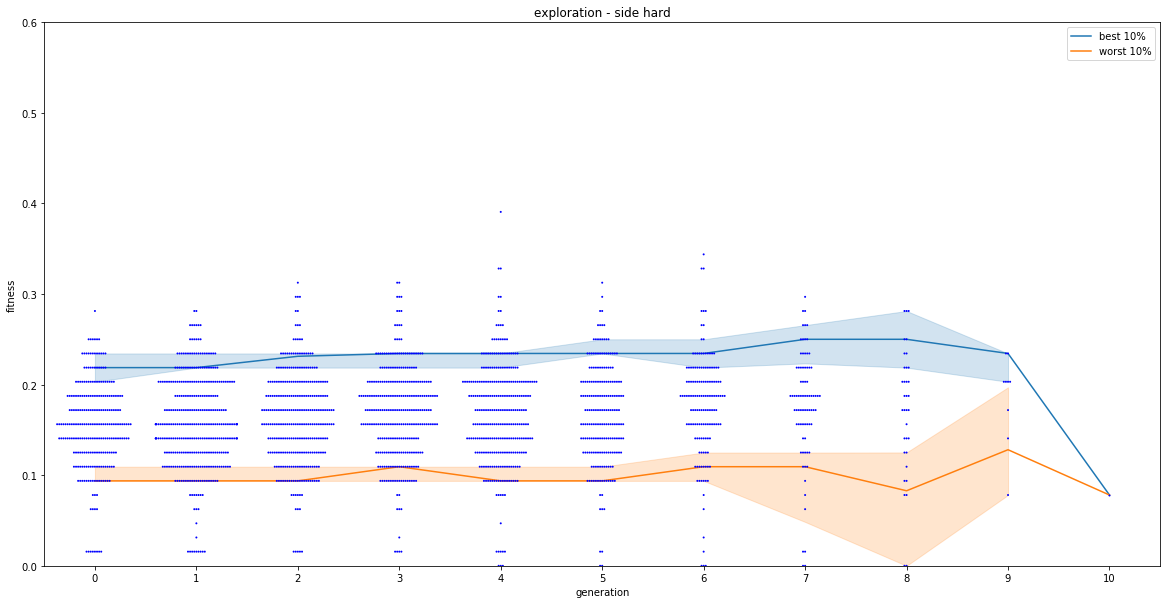

190


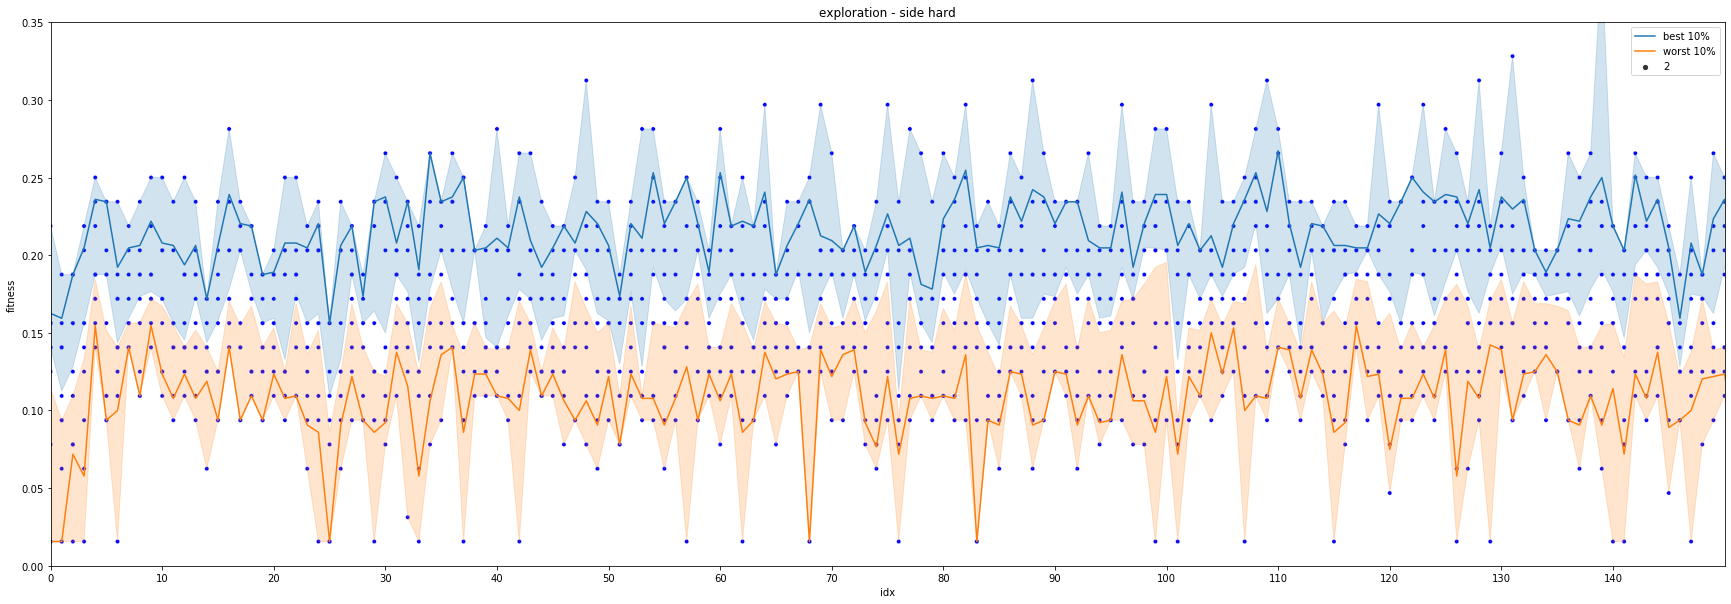

In [18]:
fig = plt.gcf()
fig.set_size_inches(30,10)
ax = sns.scatterplot(data=data,x="idx",y="fitness",size=2,color='b')
sns.lineplot(data=data,x="idx",y="fitness",estimator=perc_high,label="best 10%")
sns.lineplot(data=data,x="idx",y="fitness",estimator=perc_low,label="worst 10%")
ax.set_title("exploration - side hard")
ax.set_ylim([0,0.35])
ax.set_xlim([0,150])
plt.xticks(range(0,150,10),range(0,150,10))
print(len(ids))

# Generation 2
## Quality

In [7]:
exp_folder = "/home/leni/are-logs/mnipes2_explo_final_experiments/gen_1/"
lines = []
i = 0
best_inds = dict()
beh_descriptors = dict()
morph_descriptors = dict()
for folder in os.listdir(exp_folder):
    i+=1
    ids, fitnesses, parents = load_fitness(exp_folder + "/" + folder + "/fitnesses.csv")
    indexes = np.argsort(np.array(fitnesses))
    best_inds[folder] = [[ids[indexes[-i]],fitnesses[indexes[-i]]*64] for i in range(1,6)]
    print(folder,best_inds[folder])
    generation = compute_generation(ids,parents)
    for idx, _id, fit, gen in zip(range(len(ids)),ids,fitnesses,generation):    
        lines.append([idx+100,_id,fit,gen])
  
    morph_desc = load_descriptor(exp_folder + "/" + folder + "/morph_descriptors.csv")
    morph_descriptors[folder] = dict()
    for desc in morph_desc:
        morph_descriptors[folder][desc[0]] = desc[1:]
print(i)
data_2 = pd.DataFrame(data=lines,columns=["idx","robot id","fitness","generation"]) 
data_2.drop_duplicates()

mnipes2_9_10_20-47-51-1423-2858225455 [[94.0, 16.0], [159.0, 15.0], [64.0, 15.0], [180.0, 15.0], [100.0, 15.0]]
mnipes2_9_10_17-2-7-7880-3327828549 [[147.0, 25.0], [185.0, 22.0], [142.0, 21.0], [162.0, 21.0], [92.0, 20.0]]
mnipes2_10_10_15-29-1-1882-86016911 [[167.0, 21.0], [122.0, 19.0], [117.0, 18.0], [188.0, 18.0], [33.0, 18.0]]
mnipes2_10_10_10-10-20-371-1854220728 [[192.0, 18.0], [176.0, 17.0], [88.0, 17.0], [35.0, 17.0], [27.0, 17.0]]
mnipes2_9_10_23-6-32-2380-2046351755 [[162.0, 14.0], [78.0, 13.0], [200.0, 13.0], [192.0, 13.0], [174.0, 12.0]]
mnipes2_9_10_20-47-36-7003-2810200260 [[185.0, 19.0], [208.0, 18.0], [196.0, 18.0], [186.0, 17.0], [171.0, 17.0]]
mnipes2_12_10_13-14-10-380-2957617507 [[64.0, 20.0], [13.0, 18.0], [141.0, 17.0], [93.0, 16.0], [161.0, 16.0]]
mnipes2_9_10_18-38-31-1485-586218950 [[198.0, 21.0], [132.0, 19.0], [90.0, 19.0], [190.0, 18.0], [109.0, 18.0]]
mnipes2_9_10_21-40-37-7863-2849457699 [[125.0, 18.0], [32.0, 16.0], [71.0, 16.0], [181.0, 16.0], [97.0, 15

,idx,robot id,fitness,generation
0,100,24.0,0.078125,0
1,101,18.0,0.109375,0
2,102,2.0,0.109375,0
3,103,13.0,0.156250,0
4,104,0.0,0.171875,0
...,...,...,...,...
1893,285,201.0,0.109375,6
1894,286,207.0,0.109375,6
1895,287,203.0,0.187500,6
1896,288,206.0,0.109375,5


190


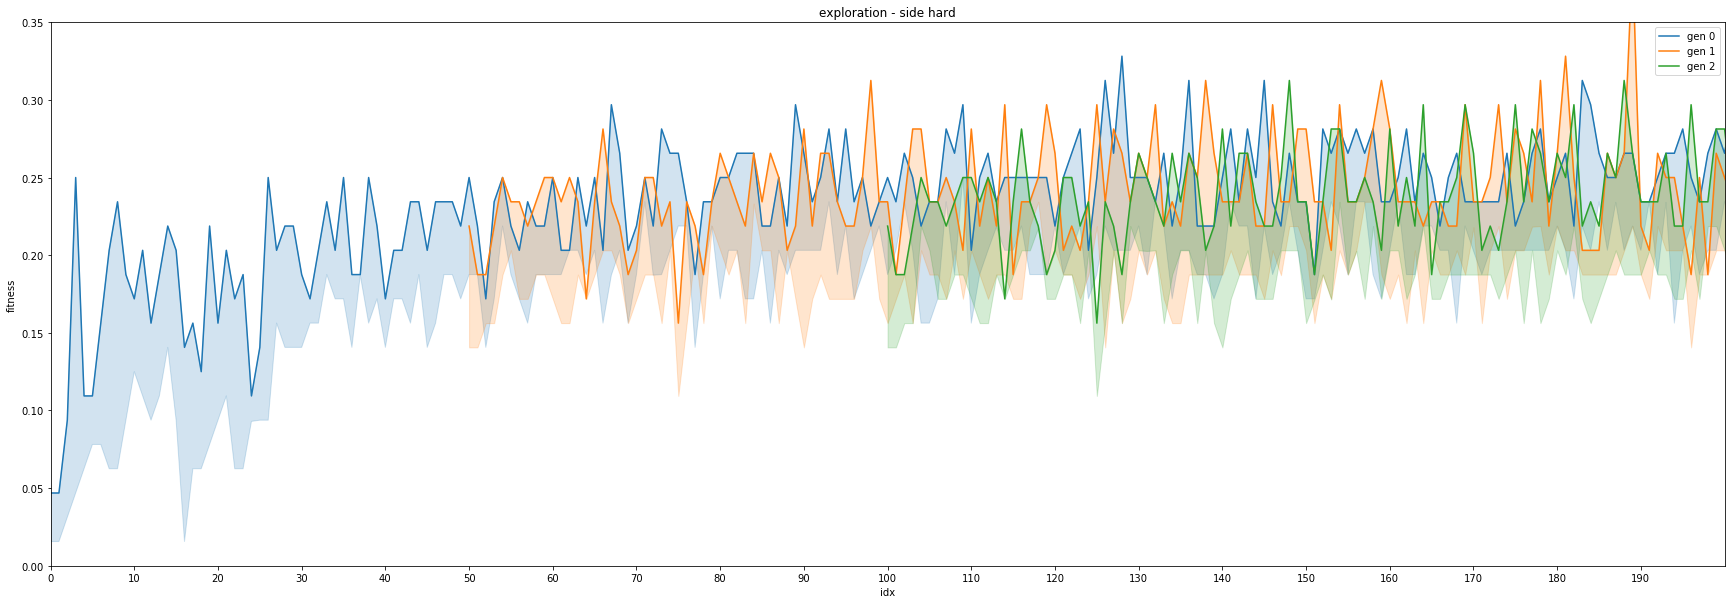

In [10]:
fig = plt.gcf()
fig.set_size_inches(30,10)
ax = sns.lineplot(data=data,x="idx",y="fitness",estimator=np.max,label="gen 0")
sns.lineplot(data=data_1,x="idx",y="fitness",estimator=np.max,label="gen 1")
sns.lineplot(data=data_2,x="idx",y="fitness",estimator=np.max,label="gen 2")
ax.set_title("exploration - side hard")
ax.set_ylim([0,0.35])
ax.set_xlim([0,200])
plt.xticks(range(0,200,10),range(0,200,10))
print(len(ids))